Fitting 5 folds for each of 21 candidates, totalling 105 fits
1316 rows in training set
Found 3810 unique words in texts
Loaded 94 stop words from /home/od13/addons/tender_cat/data/model/trained/1/2020_stop_word.txt
Loaded 189 stop words from /home/od13/addons/tender_cat/data/model/trained/1/stop_words.mod
Now 189 unique words in stop-word list
Stop words cleaned from texts
Deleted 0 texts containing stop-words only
1316 rows in training set
1316 rows in training set
0 attention words marked
719 words replaced with nice form
--------------------------------------
best_params:
{'deep_sim__epochs': 500, 'deep_sim__sim_coef': 3, 'deep_sim__stack_size': 1}
--------------------------------------
best_estimator:
Pipeline(steps=[('clean_text', CleanText()), ('clean_punct', CleanPunct()),
                ('stop_word',
                 StopWord(save_frequency_to_csv=None,
                          trained_folder='/home/od13/addons/tender_cat/data/model/trained/1')),
                ('clean_numb

/home/od13/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 101 out of 105 | elapsed:  5.4min remainin

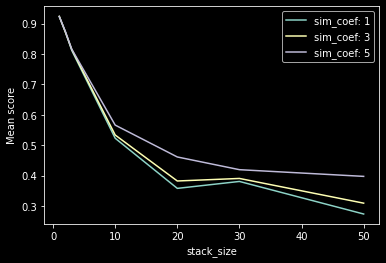

In [1]:
import csv, os, joblib, re, math, logging, gensim
from datetime import datetime
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from uk_stemmer import UkStemmer
from gensim.models import Phrases
from gensim.parsing import preprocessing
from pprint import pprint
from pyhash import murmur3_x64_128
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

_logger = logging.getLogger(__name__)
_set_name = 'training set'
_no_label_id = 1001
_no_label_name = '?'

_debug_csv = '/home/od13/addons/tender_cat/data/model/debug0.csv'
_test_set_csv = '/home/od13/addons/tender_cat/data/model/test_set.csv'

#_data_folder='/home/od13/addons/tender_cat/data/model/dump/1'
_data_folder='/home/od13/addons/tender_cat/data0/model/dump/1'
_model_folder='/home/od13/addons/tender_cat/data/model/trained/1'

def log(msg):
    if len(str(msg)) > 255:
        pprint(msg)
    else:
        print(msg)
    _logger.info(msg)

def print_sorted(source_df, column, topn=10, msg='', text_column='text', ascending=False):
    log('\nTop {} {}: '.format(topn, msg))
    sort_df = pd.concat([source_df[column],source_df[text_column]], axis=1)
    sort_df.apply(lambda row: int(row[column]), axis=1)
    sort_df.drop_duplicates(subset=text_column, inplace=True)
    top = topn
    for i, row in sort_df.sort_values(column, ascending=ascending).iterrows():
        log('{} {}'.format(row[column], row[text_column]))
        top -= 1
        if not top:
            break

def hash_str(hasher, string):
    return str(hasher(str(string).strip()))

def print_most_freq(source_df, column, top, msg='', reverse=True):
        log('\nTop {} {}: '.format(top, msg))
        freq_dct = dict(source_df[column].value_counts())
        for w in sorted(freq_dct, key=freq_dct.get, reverse=reverse):
            print(freq_dct[w], w)
            top -= 1
            if not top:
                break

def get_subfolder(root, sub):
    fdir = os.path.join(root, sub)
    if not os.path.isdir(fdir):
        os.makedirs(fdir)
    return fdir

def folder_csv_to_dataframe(folder):
    csvs = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(".csv"):
                try:
                    csvs.append(pd.read_csv(os.path.join(folder, f)))
                except (FileExistsError, IOError, pd.errors.EmptyDataError) as e:
                    _logger.error('{}: {}'.format(f, e))
    if csvs:
        return pd.concat(csvs, ignore_index=True)
    else:
        return pd.DataFrame()

def log_size(X, msg=None):
    log_msg = '{} rows in {}'.format(X.shape[0], _set_name)
    if msg is not None:
        log_msg += ', {}'.format(msg)
    log(log_msg)

def word_src(source_df, column):
    for i, row in source_df.iterrows():
        txt = str(row[column]).strip()
        if txt:
            yield txt.split()

def drop_epmty(X, column, msg=''):
        start_len = X.shape[0]
        #X = X.drop(X[X[column] == ''].index)
        #log('Deleted {} rows {}'.format(start_len - X.shape[0], msg))
        return X

class PreprocessDF(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #log('--- PreprocessDF transform')
        # X.fillna(inplace=True, value={'label_id': self.no_label_id,'label_name': self.no_label_name})
        # X.label_id = X.label_id.astype(int)
        log_size(X, 'preprocessed')
        return X

class CleanText(BaseEstimator, TransformerMixin):

    def clean_txt(self, origin_txt):

        txt = origin_txt.strip()

        url_pattern = r'https?://\S+|http?://\S+|www\.\S+'
        txt = re.sub(pattern=url_pattern, repl=' ', string=txt)

        #number_pattern = r'\d+'
        #txt = re.sub(pattern=number_pattern, repl="nmbr", string=txt)
        #txt = re.sub(pattern=number_pattern, repl=" ", string=txt)

        single_char_pattern = r'\s+[a-zA-Z]\s+'
        txt = re.sub(pattern=single_char_pattern, repl=" ", string=txt)

        txt = gensim.utils.decode_htmlentities(gensim.utils.deaccent(txt))

        space_pattern = r'\s+'
        txt = re.sub(pattern=space_pattern, repl=" ", string=txt)

        # All characters are non alfa or latin characters
        # or abbreviations
        if re.match("^[\d .«»,-:+*_;%@\\/(A-Z)(\d*\s*х\d*\s*)(С|м|шт|кг|т|СН)]+$",
                    txt, flags=re.IGNORECASE):
            txt = ''

        # Emails and email captions
        pattern = r'(email|e-mail)\:+'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)

        pattern = r'([\S*|\d*])*@([\S*|\d*])*(\s?)'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)

        # Phone captions
        pattern = r'(тел.|тел.)[\:|\s*]+'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)
        pattern = r'(факс)[\:|\s*]+'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)

        # Phone numbers
        # (095) 354-25-25
        pattern = r'(\(\d{1,7}\)\s*\d{1,5}-\d{1,5}-\d{1,5})'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)
        # 06264–2-01-35
        pattern = r'\s*(\d{1,7}–\d{1,5}–\d{1,5}–\d{1,5})'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)
        # +380993004541
        pattern = r'\+(\d{5,15})'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)

        # М.П.
        pattern = r'(м.п.)[^\w]*'
        txt = re.sub(pattern=pattern, repl="", string=txt, flags=re.IGNORECASE)

        txt = txt.strip()

        return txt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #log('--- CleanText transform')

        X['clean_text'] = X['text'].apply(lambda x: self.clean_txt(x).lower())

        X = drop_epmty(X, 'clean_text', 'after cleaning')
        log_size(X)
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        return X

class StopText(BaseEstimator, TransformerMixin):

    def __init__(self, folder, save_frequency_to_csv=False):
        self.frequency_to_csv = save_frequency_to_csv
        self.stop_text = []
        self.data_folder = folder
        self.stat = {'chr_max': 0, 'chr_min': 0, 'chr_mean': 0 }

    def fit(self, X, y=None):
        """
        Read files named any-prefix-stop_text.txt from data folder, load their content as stop-texts
        """
        fdir = os.path.join(self.data_folder)
        for f in os.listdir(fdir):
            if os.path.isfile(os.path.join(fdir, f)):
                if f.endswith("stop_text.txt"):
                    fname = os.path.join(fdir, f)
                    with open(fname, "r") as file:
                        cnt = 0
                        for line in file:
                            line_lst = list(line.strip().split(" "))
                            txt = ' '.join(line_lst[1:])
                            self.stop_text.append(txt)
                            cnt += 1
                        log('Loaded {} stop texts from {}'.format(cnt, fname))
        self.stop_text = list(set(self.stop_text))

        # Count characters
        X['chr_count'] = X.apply(lambda row: len(row['clean_text']), axis=1)
        stat = {
            'chr_max': X['chr_count'].max(),
            'chr_min': X['chr_count'].min(),
            'chr_mean': X['chr_count'].mean()
        }

        log('Character counts in texts: min {}, max {},  mean {}'
            .format(stat['chr_min'], stat['chr_max'], stat['chr_mean']))
        self.stat.update(stat)

        return self

    def transform(self, X):
        """
        Delete stop-texts from X. Write text frequency to text file before this
        (if enabled by arg save_frequency_to_csv)
        """
        #log('--- StopText transform')
        if self.frequency_to_csv:
            # Save sorted text frequency to text file
            fdir = os.path.join(self.data_folder, 'stop_text')
            if not os.path.isdir(fdir):
                os.makedirs(fdir)
            fname = os.path.join(get_subfolder(self.data_folder, 'stop_text'),
                                 datetime.today().strftime('%Y_%m_%d_%H_%M_%S')+'_stop_text.txt')
            with open(fname, 'w') as f:
                freq_dct = dict(X['clean_text'].value_counts())
                text = ''
                for w in sorted(freq_dct, key=freq_dct.get, reverse=True):
                    text += '{} {}\n'.format(freq_dct[w], w)
                f.write(text)
                log('Saved to {} {} texts'.format(fname, len(freq_dct)))

        start_len = X.shape[0]
        #X = X.drop(X[X['clean_text'].isin(self.stop_text)].index)
        X.loc[X['clean_text'].isin(self.stop_text), 'clean_text'] = ''
        log('{} rows containing stop-text deleted from training set'.format(start_len - X.shape[0]))
        log_size(X)

        # Delete too long and too short texts
        stat = self.stat
        #print_sorted(X,'chr_count',topn=100,ascending=True)
        start_len = X.shape[0]
        #X = X.drop(X[X.chr_count >= stat['chr_max'] ].index)
        X.loc[X.chr_count >= stat['chr_max'], 'clean_text'] = ''
        log('Deleted {} long texts, {} character length'.format(start_len - X.shape[0], stat['chr_max']))

        start_len = X.shape[0]
        #X = X.drop(X[X.chr_count <= stat['chr_min']+1].index)
        X.loc[X.chr_count <= stat['chr_min']+1, 'clean_text'] = ''
        log('Deleted {} short texts, {} and less characters length'.format(start_len - X.shape[0], stat['chr_min']+1))
        log_size(X)
        return X

class StopWordTrain(BaseEstimator, TransformerMixin):

    def is_dirty_word(self, word):
        # All characters are non alfa or latin characters
        # or abbreviations
        if re.match('^[\d  .,-«»:+*_;%@\\/(A-Z)(\d*\s*х\d*\s*)№(С|м|шт|кг|т|СН)]+$',
                    word,
                    flags=re.IGNORECASE):
            return True

        return False

    def __init__(self, folder, save_frequency_to_csv=False):
        self.frequency_to_csv = save_frequency_to_csv
        self.stop_words = []
        self.trained_folder = folder
        self.stat = {'min': 0, 'max': 0, 'mean': 0 }
        self.word_df = pd.DataFrame(columns=['word'])
        self.file_name = os.path.join(self.trained_folder, 'stop_words.mod')

    def fit(self, X, y=None):

        all_words = []
        for word_lst in word_src(X,'clean_text'):
            for word in word_lst:
                all_words.append(word)
        self.word_df = pd.DataFrame(all_words, columns=['word'])
        log('Found {} unique words in texts'.format(self.word_df['word'].nunique()))

        freq_word_dct = dict(self.word_df['word'].value_counts())
        cnt = 0
        for w in freq_word_dct:
             if freq_word_dct[w] == 1:
                 if self.is_dirty_word(w):
                    self.stop_words.append(w)
                    cnt += 1
        log('{} dirty rare words added to stop list'.format(cnt))

        fdir = os.path.join(self.trained_folder)
        for f in os.listdir(fdir):
            if os.path.isfile(os.path.join(fdir, f)):
                if f.endswith("stop_word.txt"):
                    fname = os.path.join(fdir, f)
                    with open(fname, "r") as file:
                        cnt = 0
                        for line in file:
                            line_lst = list(line.strip().split(" "))
                            txt = ' '.join(line_lst[1:])
                            self.stop_words.append(txt)
                            cnt += 1
                        log('Loaded {} stop words from {}'.format(cnt, fname))
        self.stop_words = list(set(self.stop_words))

        self.word_df = self.word_df.drop(self.word_df[self.word_df.word.isin(self.stop_words)].index)
        #print_most_freq(self.word_df, 'word', 200, msg='frequent words')
        #print_most_freq(self.word_df, 'word', 1000, msg='rare words', reverse=False)

        with open(self.file_name, 'w') as f:
            text = ''
            for w in self.stop_words:
                text += '{}\n'.format(w)
            f.write(text)
            log('Stop words saved to {}'.format(self.file_name))

        return self

    def transform(self, X):
        #log('--- StopWord transform')
        if self.frequency_to_csv:
            # Save sorted word frequency to text file
            fname = os.path.join(get_subfolder(self.file_name, 'stop_word'),
                                 datetime.today().strftime('%Y_%m_%d_%H_%M_%S')+'_stop_word.txt')
            with open(fname, 'w') as f:
                freq_dct = dict(self.word_df['word'].value_counts())
                text = ''
                for w in sorted(freq_dct, key=freq_dct.get, reverse=True):
                    text += '{} {}\n'.format(freq_dct[w], w)
                f.write(text)
                log('Saved {} words to {}'.format(len(freq_dct), fname))

        if os.path.isfile(self.file_name):
            with open(self.file_name, "r") as file:
                cnt = 0
                for line in file:
                    self.stop_words.append(line.strip())
                    cnt += 1
                log('Loaded {} stop words from {}'.format(cnt, self.file_name))

        X['clean_text'] = X['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in self.stop_words]).strip())
        log('Stop words cleaned from texts')
        start_len = X.shape[0]
        #X = X.drop(X[X.clean_text.isin(self.stop_words)].index)
        X.loc[X.clean_text.isin(self.stop_words), 'clean_text'] = ''
        # X = X.drop(X[X.clean_text == ''].index)
        log('Deleted {} texts containing stop-words only'.format(start_len - X.shape[0]))
        log_size(X)
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])

        return X

class StopWord(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder='', save_frequency_to_csv=False):
        self.frequency_to_csv = save_frequency_to_csv
        self.stop_words = []
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'stop_words.mod')
        self.word_df = pd.DataFrame(columns=['word'])

    def fit(self, X, y=None):
        all_words = []
        for word_lst in word_src(X,'clean_text'):
            for word in word_lst:
                all_words.append(word)
        self.word_df = pd.DataFrame(all_words, columns=['word'])
        log('Found {} unique words in texts'.format(self.word_df['word'].nunique()))

        self.stop_words = []

        fdir = os.path.join(self.trained_folder)
        for f in os.listdir(fdir):
            if os.path.isfile(os.path.join(fdir, f)):
                if f.endswith("stop_word.txt"):
                    fname = os.path.join(fdir, f)
                    with open(fname, "r") as file:
                        cnt = 0
                        for line in file:
                            line_lst = list(line.strip().split(" "))
                            txt = ' '.join(line_lst[1:])
                            self.stop_words.append(txt)
                            cnt += 1
                        log('Loaded {} stop words from {}'.format(cnt, fname))
        if os.path.isfile(self.file_name):
            with open(self.file_name, "r") as file:
                cnt = 0
                for line in file:
                    self.stop_words.append(line.strip())
                    cnt += 1
                log('Loaded {} stop words from {}'.format(cnt, self.file_name))

        self.stop_words = list(set(self.stop_words))
        log('Now {} unique words in stop-word list'.format(len(self.stop_words)))

        return self

    def transform(self, X):
        #log('--- StopWord transform')
        if self.frequency_to_csv:
            # Save sorted word frequency to text file
            fname = os.path.join(get_subfolder(self.file_name, 'stop_word'),
                                 datetime.today().strftime('%Y_%m_%d_%H_%M_%S')+'_stop_word.txt')
            with open(fname, 'w') as f:
                freq_dct = dict(self.word_df['word'].value_counts())
                text = ''
                for w in sorted(freq_dct, key=freq_dct.get, reverse=True):
                    text += '{} {}\n'.format(freq_dct[w], w)
                f.write(text)
                log('Saved {} words to {}'.format(len(freq_dct), fname))

        X['clean_text'] = X['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in self.stop_words]).strip())
        log('Stop words cleaned from texts')
        start_len = X.shape[0]
        # X = X.drop(X[X.clean_text.isin(self.stop_words)].index)
        # X = X.drop(X[X.clean_text == ''].index)
        X.loc[X.clean_text.isin(self.stop_words), 'clean_text'] = ''
        log('Deleted {} texts containing stop-words only'.format(start_len - X.shape[0]))
        log_size(X)
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        return X

class NiceStemWords(BaseEstimator, TransformerMixin):

    def __init__(self, folder=''):
        self.data_folder = folder
        self.nice_forms = {
            'електронні': 'електронн',
            'статте': 'статт',
            'статті': 'статт',
            'пропозиці': 'пропозиц',
            'спрощено': 'спрощен',
            'осіб': 'особ',
            'тендерно': 'тендерн',
            'україн': 'украін',
            'уповноважено': 'уповноважен',
            'договірно': 'договірн',
            'договор': 'договір',
            'фізично': 'фізичн',
            'юридично': 'юридичн',
            'днів': 'день',
            'дня': 'день',
            'можут': 'мож',
            'вартост': 'вартіст',
            'банківсько': 'банківськ',
            'банківськи': 'банківськ',
            'відміня': 'відмін',
            }
        self.counter = 0

    def make_nice_word(self, word):
        if word in self.nice_forms:
            self.counter += 1
            return self.nice_forms[word]
        return word

    def fit(self, X, y=None):
        self.counter = 0
        return self

    def transform(self, X):
        #log('--- NiceStemWords transform')
        X['clean_text'] = X['clean_text'].apply(lambda x:' '.join([self.make_nice_word(w) for w in x.split()]))
        log('{} words replaced with nice form'.format(self.counter))
        return X

class AttentionWord(BaseEstimator, TransformerMixin):

    def __init__(self, folder=''):
        self.data_folder = folder
        self.attention_words = ['допуск', '123']
        self.counter = 0

    def mark_attention_word(self, word):
        if word in self.attention_words:
            self.counter += 1
            return '_{}_'.format(word)
        return word

    def fit(self, X, y=None):
        self.counter = 0
        return self

    def transform(self, X):
        #log('--- AttentionWord transform')
        X['clean_text'] = X['clean_text'].apply(lambda x:' '.join([self.mark_attention_word(w) for w in x.split()]))
        log('{} attention words marked'.format(self.counter))
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        return X

class CleanPunct(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #log('--- CleanPunct transform')
        X['clean_text'] = X['clean_text'].apply(lambda x: preprocessing.strip_punctuation(x))
        X['clean_text'] = X['clean_text'].apply(lambda x: preprocessing.strip_multiple_whitespaces(x).strip())
        pattern = r'[«»]'
        X['clean_text'] = X['clean_text'].apply(lambda x: re.sub(pattern=pattern, repl="", string=x).strip())
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        # print_most_freq(X, 'clean_text', 500, msg='frequent texts')
        return X

class CleanNumberedLists(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #log('--- CleanNumberedLists transform')
        pattern = r'^\d+[(.\d+){1,5}]*(\)*|\s+|\\.*)'
        X['clean_text'] = X['clean_text'].apply(lambda x: re.sub(pattern=pattern, repl="", string=x).strip())
        # X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        X = drop_epmty(X, 'clean_text', 'after numbered lists cleaning')
        log_size(X)
        return X

class NGram(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder=''):
        self.ngram = None
        self.ngram_column = None
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'ngram.mod')

    def generate_ngrams(self, src_df, n, min_count=10, threshold=25):
        column_name = 'clean_text' if n==2 else str(n)+'gram_text'
        prev_column_name = 'clean_text' if (n-1)==1 else str((n-1))+'gram_text'

        gram_model = Phrases(word_src(src_df, prev_column_name), min_count, threshold)
        gram_list = []
        for txt in word_src(src_df, prev_column_name):
            gram_txt = gram_model[txt]
            for word in gram_txt:
                if len(word.split('_'))==n:
                    gram_list.append(word)
        gram_df = pd.DataFrame(gram_list, columns=['word'])
        src_df[str(n)+'gram_text'] = src_df.apply(lambda row: ' '.join(gram_model[row[prev_column_name].split()]), axis=1)

        if not prev_column_name == 'clean_text':
            del src_df[prev_column_name]

        self.ngram = gram_model
        self.ngram_column = column_name
        return gram_df

    def fit(self, X, y=None):
        gram_df = self.generate_ngrams(X, 2)

        joblib.dump({
            'ngram': self.ngram,
        }, self.file_name)
        log('Trained ngram model saved to {}'.format(self.file_name))

        #print_most_freq(gram_df, 'word', 1000)
        #gram_df.drop_duplicates(subset='word', inplace=True)
        #gram_df.to_csv(_debug_csv, columns=['word'])
        return self

    def transform(self, X):
        #log('--- NGram transform')
        X['clean_text'] = X.apply(lambda row: ' '.join(self.ngram[row['clean_text'].split()]), axis=1)
        #X.to_csv(_debug_csv, columns=['clean_text', 'text', 'hash'])
        return X

class StemWords(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.stemmer = UkStemmer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #log('--- StemWords transform')
        X['clean_text'] = X['clean_text'].apply(lambda x:' '.join([self.stemmer.stem_word(w) for w in x.split()]))
        # X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        return X

class TextRegistryTrain(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder=''):
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'text_registry.csv')

    def fit(self, X, y=None):
        #log('--- TextUIDTrain fit')
        hasher = murmur3_x64_128()
        X['uid'] = X.apply(lambda row: hash_str(hasher, row['clean_text']), axis=1)
        columns = ['uid', 'label_id', 'label_name', 'text', 'clean_text']
        df = X[columns].copy()
        df.drop_duplicates(subset=['uid'], inplace=True)
        log('{} text UIDs saved to {}'.format(df.shape[0], self.file_name))
        df.to_csv(self.file_name, columns=columns)
        return self

    def transform(self, X):
        #log('--- TextUIDTrain transform')
        return X

class Doc2vecTrain(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder=''):
        self.doc2vec = None
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'vec_base.mod')

    def tagged_doc_src(self, src_df, column):
        for index, row in src_df.iterrows():
            word_lst = str(row[column]).split()
            if word_lst:
                yield gensim.models.doc2vec.TaggedDocument(word_lst, [str(row['uid'])])

    def fit(self, X, y=None):
        #log('--- Doc2vecTrain fit')
        train_corp = list(self.tagged_doc_src(X, column='clean_text'))
        log('Prepared train corpus for Doc2vec, {} texts'.format(len(train_corp)))
        #pprint(train_corp[:20])
        #[6.1, 300, 200, 2] [7.4, 50, 100, 2] [6.1, 250, 100, 2] [7.7, 100, 100, 2]
        vector_size, epochs, window = 300, 200, 2
        log('Creating doc2vec model with hyperparameters: vector_sizes {} epochs {} window {} ...'.format(vector_size, epochs, window))
        self.doc2vec = gensim.models.doc2vec.Doc2Vec(documents=train_corp, vector_size=vector_size, window=window, min_count=1, workers=8, epochs=epochs)
        log('Doc2vec model is ready, vocabulary {}'.format(len(self.doc2vec.wv.vocab)))
        #pprint(self.vectorizer.wv.vocab)
        joblib.dump({
            'doc2vec': self.doc2vec,
        }, self.file_name)
        log('Trained Doc2vec model saved to {}'.format(self.file_name))

        return self

    def transform(self, X):
        #log('--- Doc2vecTrain transform')
        X.to_csv(_debug_csv, columns=['clean_text', 'text', 'uid'])
        return X

class NGramDB(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder=''):
        self.ngram = None
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'ngram.mod')

    def fit(self, X, y=None):
        #log('--- NgramDB fit')
        model_dct = joblib.load(self.file_name)
        self.ngram = model_dct['ngram']
        return self

    def transform(self, X):
        #log('--- NgramDB transform')
        X['clean_text'] = X.apply(lambda row: ' '.join(self.ngram[row['clean_text'].split()]), axis=1)
        #X.to_csv(_debug_csv, columns=['clean_text', 'text'])
        return X

class TextRegistryDB(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder=''):
        self.reg_df = None
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'text_registry.csv')

    def fit(self, X, y=None):
        # log('--- TextRegistryDB fit')
        self.reg_df = pd.read_csv(self.file_name, usecols=['uid','label_id', 'label_name', 'text', 'clean_text'])
        self.reg_df.label_id = self.reg_df.label_id.astype(int)
        #log(self.reg_df.head())
        return self

    def transform(self, X):
        # log('--- TextRegistryDB transform')
        X['uid'] = None
        hasher = murmur3_x64_128()
        for i, row in X.iterrows():
            X.loc[i, 'uid'] = hash_str(hasher, row['clean_text'])
            # row['uid'] = hash_str(hasher, row['clean_text'])
            # reg_rows = self.reg_df.loc[self.reg_df.uid == row['uid']]
            # if not reg_rows.empty:
            #     row['label_id'] = reg_rows['label_id'].values.tolist()[0]
            #     row['label_name'] = reg_rows['label_name'].values.tolist()[0]
        return X

class DeepSimProd(BaseEstimator, TransformerMixin):

    def __init__(self, trained_folder='', sim_coef=3, stack_size=3, epochs=1000):
        self.trained_folder = trained_folder
        self.file_name = os.path.join(trained_folder, 'deep_sim.mod')
        self.doc2vec_file_name = os.path.join(trained_folder, 'vec_base.mod')

        self.text_registry = None
        self.doc2vec_db = None

        self.stack_size = stack_size
        self.sim_coef = sim_coef
        self.epochs = epochs

        self.label_stat = None

    def ivec(self, word_list, alpha=0.025):
        if self.doc2vec_db:
            return self.doc2vec_db.infer_vector(word_list, epochs=self.epochs)
        else:
            return []

    def most_similar(self, vec, topn=30):
        similars = []
        sims = self.doc2vec_db.docvecs.most_similar(positive=[vec], topn=topn)

        reg_df = self.text_registry.reg_df

        for doc_id, sim in sims:
            found_rows = reg_df[reg_df.uid == doc_id]
            similars.append({
                'uid': doc_id,
                'label_name': found_rows['label_name'],
                'label_id': found_rows['label_id'],
                'text': found_rows['text'],
                'clean_text': found_rows['clean_text'],
                'sim': sim,
            })
        return similars

    def update_label_stat(self):
        tdf = self.text_registry.reg_df
        label_freq = {}
        label_names = {}
        label_norm_freq = {}
        total_cnt = 0
        max_count = 0
        for i, row in tdf.groupby('label_id').nunique().iterrows():
            cnt = row['uid']
            label_freq[i] = cnt
            total_cnt += cnt

            if cnt > max_count:
                max_count = cnt

            label_names[i] = tdf.loc[tdf['label_id'] == i, 'label_name'].iloc[0]
            # calc unique texts count instead

        for label_id in label_freq:
            label_norm_freq[label_id] = label_freq[label_id]/max_count

        self.label_stat = {
            'freq': label_freq,
            'norm_freq': label_norm_freq,
            'name': label_names,
            'total_cnt': total_cnt,
        }

    def fit(self, X, y=None):
        #log('--- DeepSimProd fit')
        self.text_registry = TextRegistryDB(trained_folder=self.trained_folder)
        self.text_registry.fit(X, y)

        model_dct = joblib.load(self.doc2vec_file_name)
        self.doc2vec_db = model_dct['doc2vec']

        self.update_label_stat()
        #log(self.label_stat)
        return self

    def transform(self, X):
        #log('--- DeepSimProd transform')

        X['label_id'].fillna(inplace=True, value=_no_label_id)
        X.label_id = X.label_id.astype(int)
        X['label_name'].fillna(inplace=True, value=_no_label_name)

        X = self.text_registry.transform(X)

        for i, row in X.iterrows():
            vec=self.ivec(str(row['clean_text']).split())
            sims = self.most_similar(vec, topn=self.stack_size)
            labels_cnt = {}
            labels_sim = {}

            for sim in sims:
                try:
                    label_id = sim['label_id'].iloc[0]
                except:
                    continue

                if label_id in labels_cnt:
                    labels_cnt[label_id] += 1
                    labels_sim[label_id] += math.pow(sim['sim'], self.sim_coef)
                else:
                    labels_cnt[label_id] = 1
                    labels_sim[label_id] = math.pow(sim['sim'], self.sim_coef)

            labels_score = {}

            for label_id in labels_cnt:
                # Fraction of particular label set
                norm_freq = math.log(1+labels_cnt[label_id])/self.label_stat['freq'][label_id]
                total_norm_freq = norm_freq

                # Look at similarity
                score = total_norm_freq*labels_sim[label_id]

                labels_score[label_id] = score

            winner_id = sorted(labels_score, key=labels_score.get, reverse=True)[0]

            vals = {
                'label_id': winner_id,
                'label_name': self.label_stat['name'][winner_id],

            }

            sims_name = {}
            for w in sorted(labels_score, key=labels_score.get, reverse=True):
                sims_name[self.label_stat['name'][w]] = labels_score[w]
            vals.update({
                'sims': labels_score,
                'sims_named': sims_name,
                'sim': labels_score[winner_id]
            })

            X.loc[i, 'label_id'] = winner_id
            X.loc[i, 'label_name'] = self.label_stat['name'][winner_id]

            #pprint(vals['sims_named'])
            df = pd.DataFrame.from_dict(data=vals['sims_named'], orient='index', columns=['sim'])
            #pprint(df.head())
            # print_sorted(df, 0,topn=100,ascending=True)
            #pprint(vals)

        # X.loc[X.label_id == _no_label_id, 'label_id'] = ''
        # X.loc[X.label_id == _no_label_id, 'label_name'] = ''
        return X

    def predict(self, X):
        X = self.transform(X)
        y = X.iloc[0:X.shape[0]]['label_id'].values.tolist()
        return y

class ProcessNotLabeledData(BaseEstimator, TransformerMixin):

    def __init__(self, text_column='clean_text'):
        self.no_label_name = _no_label_name
        self.no_label_id = _no_label_id
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Sort labels by text's count. For each label's text check, if exist not labeled row with same text. Set label, if it is
        """
        X['label_id'].fillna(inplace=True, value=self.no_label_id)
        X.label_id = X.label_id.astype(int)
        X['label_name'].fillna(inplace=True, value=self.no_label_name)

        not_labeled_cnt = X.loc[X.label_id == self.no_label_id, 'text_id'].count()
        log('{} labeled and {} not labeled texts in training set'.format(X.shape[0]-not_labeled_cnt, not_labeled_cnt))

        df = X.groupby('label_id')['text_id'].nunique().sort_values(ascending=True).reset_index(name='count')
        # print(df)

        ids_lst = X['label_id'].unique().tolist()
        names_lst = X['label_name'].unique().tolist()
        lab_names = dict(zip(ids_lst, names_lst))

        all_labels_mask = (df.label_id != self.no_label_id)
        for label_id in df.loc[all_labels_mask, 'label_id'].tolist():
            lab_texts = X[X.label_id == label_id][self.text_column].unique().tolist()
            no_label_mask = (X.label_id == self.no_label_id) & (X[self.text_column].isin(lab_texts))
            X.loc[no_label_mask, 'label_id'] = label_id
            X.loc[no_label_mask, 'label_name'] = lab_names[label_id]

        #print('--------------------------------')
        #df = X.groupby('label_id')['text_id'].nunique().sort_values(ascending=True).reset_index(name='count')
        #print(df)
        not_labeled_cnt_after = X.loc[X.label_id == self.no_label_id, 'text_id'].count()
        log('{} texts got labels'.format(not_labeled_cnt - not_labeled_cnt_after))
        log('{} labeled and {} not labeled texts now '.format(
            X.shape[0] - not_labeled_cnt_after, not_labeled_cnt_after))
        return X

class TrainingPipeline:

    def __init__(self, data_folder=None, trained_folder=None, a=None):
        self.info = _logger.info if a is None else a.info
        self.data_folder = data_folder
        self.trained_folder = trained_folder
        self.df = pd.DataFrame()

    def fit(self, data_folder=None, trained_folder=None, a=None):

        self.info = _logger.info if a is None else a.info
        self.data_folder = self.data_folder if data_folder is None else data_folder
        self.trained_folder = self.trained_folder if trained_folder is None else trained_folder

        model_folder = self.trained_folder

        return self

    def transform(self, input_file=None, output_file=None, trained_folder=None, a=None):

        self.info = _logger.info if a is None else a.info
        self.trained_folder = self.trained_folder if trained_folder is None else trained_folder

def run():
    pass
    # df = folder_csv_to_dataframe(_data_folder)
    #
    # train_pipe = Pipeline([
    #     ('preprocess', PreprocessDF()),
    #     ('clean_text', CleanText()),
    #     ('stop_text', StopText(folder=_model_folder)),
    #     ('clean_punct', CleanPunct()),
    #     ('stop_word', StopWordTrain(folder=_model_folder)),
    #     ('clean_numbered_lists', CleanNumberedLists()),
    #     ('attention_words', AttentionWord(folder=_model_folder)),
    #     ('stemmer', StemWords()),
    #     ('nice_stemmer', NiceStemWords(folder=_model_folder)),
    #     ('ngram', NGram(folder=_model_folder)),
    #     ('text_registry_train', TextRegistryTrain(folder=_model_folder)),
    #     ('doc2vec_train', Doc2vecTrain(folder=_model_folder)),
    #     ])
    # #df=train_pipe.fit_transform(df)
    #
    # text_registry_db = TextRegistryDB(folder=_model_folder)
    # doc2vec_db = Doc2VecDB(folder=_model_folder)
    # deep_sim = DeepSimProd(folder=_model_folder, text_registry=text_registry_db, doc2vec_db=doc2vec_db)
    #
    # test_pipe = Pipeline([
    #     #('preprocess', PreprocessDF()),
    #     ('clean_text', CleanText()),
    #     #('stop_text', StopText(folder=self.trained_folder)),
    #     ('clean_punct', CleanPunct()),
    #     ('stop_word', StopWord(folder=_model_folder)),
    #     ('clean_numbered_lists', CleanNumberedLists()),
    #     ('attention_words', AttentionWord(folder=_model_folder)),
    #     ('stemmer', StemWords()),
    #     ('nice_stemmer', NiceStemWords(folder=_model_folder)),
    #     ('ngram_database', NGramDB(folder=_model_folder)),
    #     ('text_registry_database', text_registry_db),
    #     ('doc2vec_database', doc2vec_db),
    #     ('deep_sim', deep_sim),
    #     ])
    #
    # texts = [
    #     '- документ підтвердження статусу платника ПДВ або єдиного податку;',
    #     '- перелік та обсяг робіт (окремий файл) без зазначення вартост.окремих складових робот, з підтвердженням, що Учасник виконає їх у повному обсязі, за підписом керівника або уповноваженої особи Учасника - юридичної особи, фізичної особи – підприємця, завірені печаткою (при наявності).',
    #     'календарн_графік виконанн робіт відповідн наказ_міністерств регіональн розвитк будівництв украін 13 01 №2',
    #     '00 коп.).',
    #     'документами, що підтверджують повноваження посадової особи або представника учасника процедури закупівлі щодо підпису документів тендерної пропозиції',
    #     'Забезпечення тендерної пропозиції повертається у разі:',
    #     'Лист-згоду на обробку, використання, поширення та доступ до персональних даних.',
    #     'витяг з Єдиного державного реєстру юридичних осіб та фізичних осіб – підприємців (або виписка)',
    #
    # ]
    # df = pd.DataFrame(texts, columns=['text'])
    # df=test_pipe.fit_transform(df)
    # pprint(df.head(100))

def train():

    from sklearn.model_selection import train_test_split

    train_pipe = Pipeline([
        ('preprocess', PreprocessDF()),
        ('clean_text', CleanText()),
        ('stop_text', StopText(folder=_model_folder)),
        ('clean_punct', CleanPunct()),
        ('stop_word', StopWordTrain(folder=_model_folder)),
        ('clean_numbered_lists', CleanNumberedLists()),
        ('attention_words', AttentionWord(folder=_model_folder)),
        ('stemmer', StemWords()),
        ('nice_stemmer', NiceStemWords(folder=_model_folder)),
        ('ngram', NGram(trained_folder=_model_folder)),
        ('process_not_labeled', ProcessNotLabeledData()),
        ('text_registry_train', TextRegistryTrain(trained_folder=_model_folder)),
        ('doc2vec_train', Doc2vecTrain(trained_folder=_model_folder)),
        ])

    X = folder_csv_to_dataframe(_data_folder)
    X['label_id'].fillna(_no_label_id, inplace=True)
    X['label_name'].fillna(_no_label_name, inplace=True)

    transformer = ProcessNotLabeledData(text_column='text')
    X = transformer.fit_transform(X)
    y = X['label_id'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    X_test.to_csv(_test_set_csv)
    train_pipe.fit_transform(X_train)

    log('---------------------------------------------------------------')
    log('Model trained')
    log('---------------------------------------------------------------')

def cross_validate_deep_sim():

    test_pipe = Pipeline([
        #('preprocess', PreprocessDF()),
        ('clean_text', CleanText()),
        #('stop_text', StopText(folder=self.trained_folder)),
        ('clean_punct', CleanPunct()),
        ('stop_word', StopWord(trained_folder=_model_folder, save_frequency_to_csv=False)),
        ('clean_numbered_lists', CleanNumberedLists()),
        ('attention_words', AttentionWord(folder=_model_folder)),
        ('stemmer', StemWords()),
        ('nice_stemmer', NiceStemWords(folder=_model_folder)),
        ('ngram_database', NGramDB(trained_folder=_model_folder)),
        ('text_registry_database', TextRegistryDB(trained_folder=_model_folder)),
        ('deep_sim', DeepSimProd(trained_folder=_model_folder, sim_coef=1, stack_size=1, epochs=1000)),
        ])

    X_test = pd.read_csv(_test_set_csv)
    X_test['label_id'].fillna(_no_label_id, inplace=True)
    X_test['label_name'].fillna(_no_label_name, inplace=True)

    y_test = X_test['label_id']


    sim_coef = [1, 3, 5]
    stack_size = [1, 2, 3, 10, 20, 30, 50]


    search = GridSearchCV(test_pipe, scoring=['f1_micro',],
                          # cv=2,
                          verbose = 10, refit='f1_micro', n_jobs=-1,
                          param_grid={
        'deep_sim__sim_coef': sim_coef,
        'deep_sim__epochs': [500,],
        'deep_sim__stack_size': stack_size,
        },)
    search.fit(X_test, y_test)

    # print('--------------------------------------')
    # print('cv_results:')
    # print(search.cv_results_)
    print('--------------------------------------')
    print('best_params:')
    print(search.best_params_)
    print('--------------------------------------')
    print('best_estimator:')
    print(search.best_estimator_)
    #print(search.score(X, y_test))


    import matplotlib.pyplot as plt
    import numpy as np
    plt.style.use('dark_background')


    scores = search.cv_results_['mean_test_f1_micro']
    scores = np.array(scores).reshape(len(sim_coef), len(stack_size))

    for ind, i in enumerate(sim_coef):
        plt.plot(stack_size, scores[ind], label='sim_coef: ' + str(i))
    plt.legend()
    plt.xlabel('stack_size')
    plt.ylabel('Mean score')
    plt.show()

def evaluate():

    test_pipe = Pipeline([
        #('preprocess', PreprocessDF()),
        ('clean_text', CleanText()),
        #('stop_text', StopText(folder=self.trained_folder)),
        ('clean_punct', CleanPunct()),
        ('stop_word', StopWord(trained_folder=_model_folder, save_frequency_to_csv=False)),
        ('clean_numbered_lists', CleanNumberedLists()),
        ('attention_words', AttentionWord(folder=_model_folder)),
        ('stemmer', StemWords()),
        ('nice_stemmer', NiceStemWords(folder=_model_folder)),
        ('ngram_database', NGramDB(trained_folder=_model_folder)),
        ('text_registry_database', TextRegistryDB(trained_folder=_model_folder)),
        ('deep_sim', DeepSimProd(trained_folder=_model_folder, sim_coef=1, stack_size=1, epochs=1000)),
        ])


    # text_registry_db = TextRegistryDB(trained_folder=_model_folder)
    # text_registry_db.fit_transform(pd.DataFrame([], columns=['text']))
    #
    # reg_df = text_registry_db.reg_df
    # size = min(10000, reg_df.shape[0])

    #X = reg_df.iloc[0:size].copy()

    X_test = pd.read_csv(_test_set_csv)
    X_test['label_id'].fillna(_no_label_id, inplace=True)
    X_test['label_name'].fillna(_no_label_name, inplace=True)

    X = test_pipe.fit_transform(X_test)

    X_pred = X_test.copy()
    for i, row in X_pred.iterrows():
        for j, _ in X.iterrows():
            if X.loc[j, 'text_id'] == X_pred.loc[i, 'text_id']:
                X_pred.loc[i, 'label_id'] = X.loc[i, 'label_id']
                X_pred.loc[i, 'label_name'] = X.loc[i, 'label_name']
                break

    y_test = X_test['label_id']
    y_pred = X_pred['label_id']

    log('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
    report = str(classification_report(y_test, y_pred, zero_division=0,))
    print('\n{}'.format(report))


cross_validate_deep_sim()
#train()
#evaluate()




